# Bike Sharing Demand Dataset

## Import Library: 분석에 사용할 모듈 설치

In [55]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy import stats
import statsmodels.api as sm
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import warnings

warnings.filterwarnings("ignore")

pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_rows = 30
pd.options.display.max_columns = 20

plt.style.use("dark_background")

## Data Loading: 분석에 사용할 데이터 불러오기
- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals
- Source: https://www.kaggle.com/c/bike-sharing-demand/data

In [56]:
raw_data = pd.read_csv("./Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv")

## Feature Engineering: 데이터에서 시계열패턴 추출하기

In [57]:
def non_feature_engineering(data):
    data = raw_data
    data["datetime"] = pd.to_datetime(data["datetime"])
    data = data.set_index("datetime", drop=False)
    
    # Set frequency
    data = data.asfreq("H", method="ffill")
    
    return data

def feature_engineering(data):
    data = non_feature_engineering(raw_data)
    
    # Split dataset as Trend + Seasonal + Residual
    decomp = sm.tsa.seasonal_decompose(data["count"], model="additive")

    y_trend = pd.DataFrame(decomp.trend)
    y_trend.columns = ["count_trend"]
    y_trend.fillna(method="ffill", inplace=True)
    y_trend.fillna(method="bfill", inplace=True)

    y_seasonal = pd.DataFrame(decomp.seasonal)
    y_seasonal.columns = ["count_seasonal"]
    y_seasonal.fillna(method="ffill", inplace=True)
    y_seasonal.fillna(method="bfill", inplace=True)

    data = pd.concat([data, y_trend, y_seasonal], axis=1)
    
    # Add moving average
    y_roll_day = data[["count"]].rolling(24).mean()
    y_roll_day.columns = ["count_day"]
    y_roll_day.fillna(method="ffill", inplace=True)
    y_roll_day.fillna(method="bfill", inplace=True)

    y_roll_week = data[["count"]].rolling(24*7).mean()
    y_roll_week.columns = ["count_week"]
    y_roll_week.fillna(method="ffill", inplace=True)
    y_roll_week.fillna(method="bfill", inplace=True)

    data = pd.concat([data, y_roll_day, y_roll_week], axis=1)
    
    # Add difference
    y_diff = data[["count"]].diff()
    y_diff.columns = ["count_diff"]
    y_diff = y_diff.fillna(method="ffill")
    y_diff = y_diff.fillna(method="bfill")
    data = pd.concat([data, y_diff], axis=1)
    
    # Add categorical variables
    data["year"] = data["datetime"].dt.year
    data["quarter"] = data["datetime"].dt.quarter
    data["quarter2"] = data["quarter"]*(data["year"] - data["year"].min() + 1)
    data["month"] = data["datetime"].dt.month
    data["day"] = data["datetime"].dt.day
    data["hour"] = data["datetime"].dt.hour
    data["dayofweek"] = data["datetime"].dt.dayofweek
    
    # Add lagged variables
    data["count_lag1"] = data["count"].shift(1)
    data["count_lag2"] = data["count"].shift(2)

    data["count_lag1"] = data["count_lag1"].fillna(method="bfill")
    data["count_lag2"] = data["count_lag2"].fillna(method="bfill")
    
    # Add dummy variables
    data = pd.concat([data, pd.get_dummies(data["quarter"], prefix="quarter_dummy", drop_first=True)], axis=1)
    data = data.drop(["quarter"], axis=1)
    
    return data

def data_split(data):
    tr = data[data.index < "2012-07-01"]
    test = data[data.index >= "2012-07-01"]
    y_cols = ["count"]
    x_cols = [x for x in data.columns if x not in ["datetime", "casual", "registered"] + y_cols]
    x_tr = tr[x_cols]
    y_tr = tr[y_cols]
    x_te = test[x_cols]
    y_te = test[y_cols]
    return x_tr, y_tr, x_te, y_te

In [58]:
# plt.rcParams["figure.figsize"] = (14, 11)
# decomp = sm.tsa.seasonal_decompose(data["count"], model="additive")
# decomp.plot()
# plt.show()

In [59]:
# decomp = sm.tsa.seasonal_decompose(data["count"], model="multiplicative")
# decomp.plot()
# plt.show()

In [60]:
# y_diff = data[["count"]].diff()
# y_diff.plot(kind="line", figsize=(20,6), linewidth=3, fontsize=20, xlim=("2012-01-01", "2012-06-01"), ylim=(-1000,1000))
# plt.show()

## Data Understanding(Descriptive Statistics and Getting Insight from Features

In [61]:
# data.hist(bins=20, grid=False, figsize=(16, 16))
# plt.show()

In [62]:
# data.boxplot(column="count", by="season", grid=False, figsize=(12, 5))
# data.boxplot(column="casual", by="season", grid=False, figsize=(12, 5))
# data.boxplot(column="registered", by="season", grid=False, figsize=(12, 5))
# plt.show()

In [63]:
# data.boxplot(column="count", by="holiday", grid=False, figsize=(12, 5))
# data.boxplot(column="count", by="workingday", grid=False, figsize=(12, 5))
# plt.show()

In [64]:
# data[data.holiday == 1].boxplot(column="count", by="hour", grid=False, figsize=(12, 5))
# data[data.holiday == 0].boxplot(column="count", by="hour", grid=False, figsize=(12, 5))
# plt.show()

In [65]:
# data[data.workingday == 1].boxplot(column="count", by="hour", grid=False, figsize=(12, 5))
# data[data.workingday == 0].boxplot(column="count", by="hour", grid=False, figsize=(12, 5))
# plt.show()

In [66]:
# data.plot.scatter(y="count", x="dayofweek", c="temp", grid=False, figsize=(12, 5), cmap="RdYlBu")
# data.boxplot(column="count", by="dayofweek", grid=False, figsize=(12, 5))
# plt.show()

In [67]:
# data.boxplot(column="count", by="weather", grid=False, figsize=(12, 5))
# plt.show()

In [68]:
# pd.crosstab(index=data["count"], columns=data["weather"], margins=True)

In [69]:
# data.boxplot(column="count", by="temp", grid=False, figsize=(12, 5))
# plt.show()

In [70]:
# data.boxplot(column="count", by="humidity", grid=False, figsize=(12, 5))
# plt.show()

In [71]:
# data.boxplot(column="count", by="windspeed", grid=False, figsize=(12, 5))
# plt.show()

In [72]:
# data.boxplot(column="count", by="month", grid=False, figsize=(12, 5))
# plt.show()

In [73]:
# pd.plotting.scatter_matrix(data, figsize=(18, 18), diagonal="kde")
# plt.show()

In [74]:
# data.corr().style.background_gradient(cmap="Blues").set_precision(1).set_properties(**{"font-size":"9pt"})

In [75]:
# data.corr().loc[:, ["casual", "registered", "count"]].style.background_gradient().set_precision(2).set_properties(**{"font-size": "10pt"})

## Predict and Evaluation

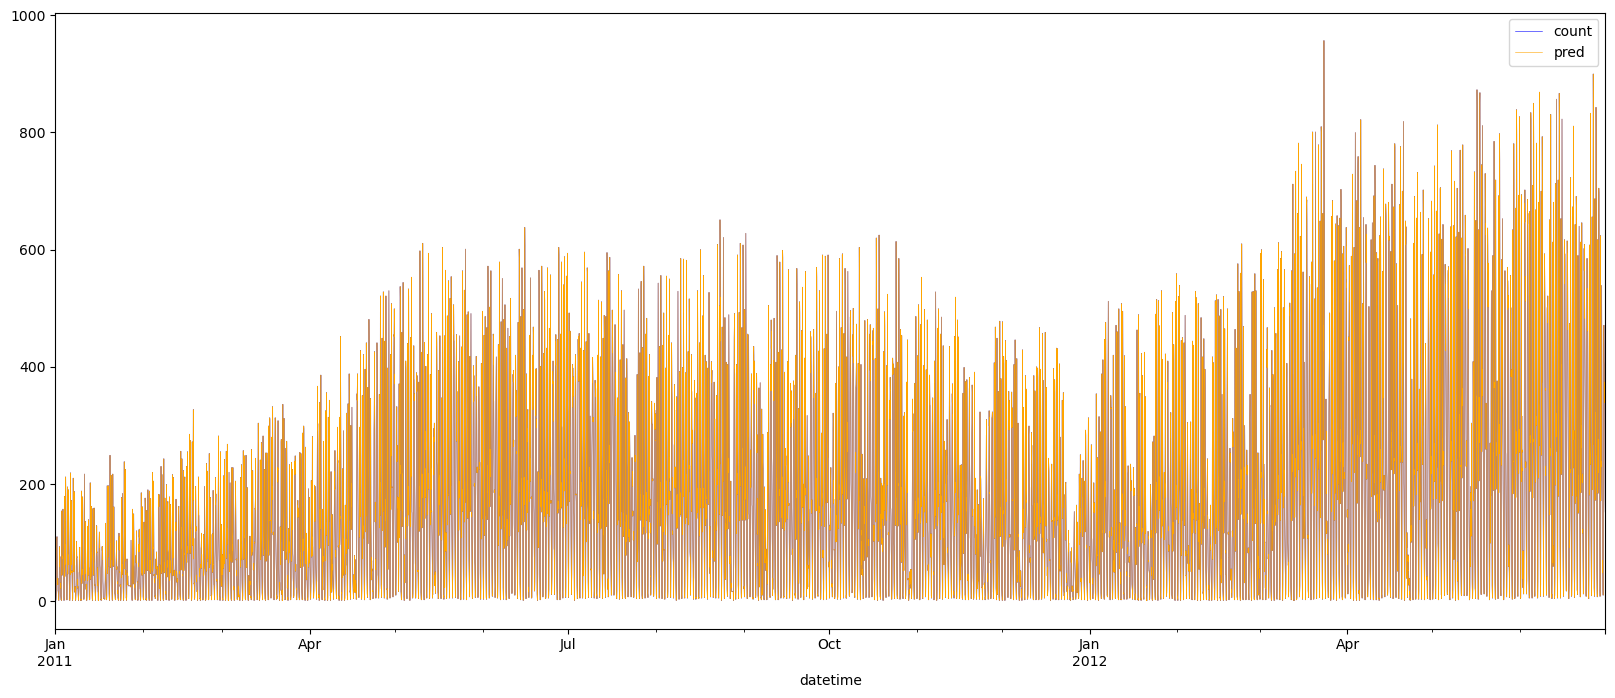

0.009 0.0438 0.0604


In [76]:
data_fe = feature_engineering(raw_data)
x_tr, y_tr, x_te, y_te = data_split(data_fe)
fit = sm.OLS(y_tr, x_tr).fit()
pred_tr_fe = fit.predict(x_tr).values
pred_te_fe = fit.predict(x_te).values

plt.style.use("default")
df = pd.concat([y_tr, pd.DataFrame(pred_tr_fe, index=y_tr.index, columns=["pred"])], axis=1)
df.plot.line(figsize=(20, 8), linewidth=0.4, fontsize=10, color=["blue", "orange"])
plt.show()

mae = round(abs(y_tr["count"].values - pred_tr_fe).mean(), 4)
mse = round(((y_tr["count"].values - pred_tr_fe)**2).mean(), 4)
mape = round((abs(y_tr["count"].values - pred_tr_fe)/y_tr["count"].values*100).mean(), 4)

print(mae, mse, mape)

In [77]:
# data_nfe = non_feature_engineering(raw_data)
# x_tr, y_tr, x_te, y_te = data_split(data_nfe)
# fit = sm.OLS(y_tr, x_tr).fit()
# # fit_reg1.summary()
# pred_tr_nfe = fit.predict(x_tr).values
# pred_te_nfe = fit.predict(x_te).values

# plt.style.use("default")
# df = pd.concat([y_tr, pd.DataFrame(pred_tr_nfe, index=y_tr.index, columns=["pred"])], axis=1)
# df.plot.line(figsize=(20, 8), linewidth=0.4, fontsize=10, color=["blue", "orange"])
# plt.show()
# plt.savefig("image.png", bbox_inches="tight")

# mae = round(abs(y_tr["count"].values - pred_tr_nfe).mean(), 4)
# mse = round(((y_tr["count"].values - pred_tr_nfe)**2).mean(), 4)
# mape = round((abs(y_tr["count"].values - pred_tr_nfe)/y_tr["count"].values*100).mean(), 4)

# print(mae, mse, mape)

In [85]:
### Functionalize
### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=["prediction"])], axis=1).plot(kind="line", figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title("Time Series of Target", fontsize=20)
        plt.xlabel("Index", fontsize=15)
        plt.ylabel("Target Value", fontsize=15)
    mae = abs(Y_real.values.flatten() - Y_pred).mean()
    mse = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([mae, mse, MAPE], index=["mae", "mse", "MAPE"], columns=["Score"]).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=["resid"])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(y_tr, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ["Train", "Test"]
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, resid_tr, Resid_te_reg1 = evaluation_trte(y_tr, pred_tr_reg1, Y_te, pred_te_reg1, graph_on=True)

In [86]:
resid_tr = pd.DataFrame(y_tr["count"].values - pred_tr_fe, index=y_tr.index, columns=["resid"])
resid_te = pd.DataFrame(y_te["count"].values - pred_te_fe, index=y_te.index, columns=["resid"])

## Error Analysis: 분석모형이 데이터패턴을 모두 추출하여 분석을 종료해도 되는지 판단하기

In [87]:
# pd.Series(sm.tsa.stattools.adfuller(resid_tr["resid"])
# sm.tsa.stattools.adfuller(resid_tr["resid"])
# pd.Series(sm.tsa.stattools.adfuller(resid_tr["resid"])[0:4], index=["Test Statistics", "p-value", "Used Lag", "Used Observations"])

## Code Summary

In [88]:
resid_tr["idx"] = resid_tr.reset_index().index
resid_tr

,resid,idx
datetime,,
2011-01-01 00:00:00,-23.95,0
2011-01-01 01:00:00,0.05,1
2011-01-01 02:00:00,0.04,2
2011-01-01 03:00:00,0.04,3
2011-01-01 04:00:00,0.04,4
...,...,...
2012-06-30 19:00:00,0.00,13123
2012-06-30 20:00:00,0.01,13124
2012-06-30 21:00:00,0.01,13125


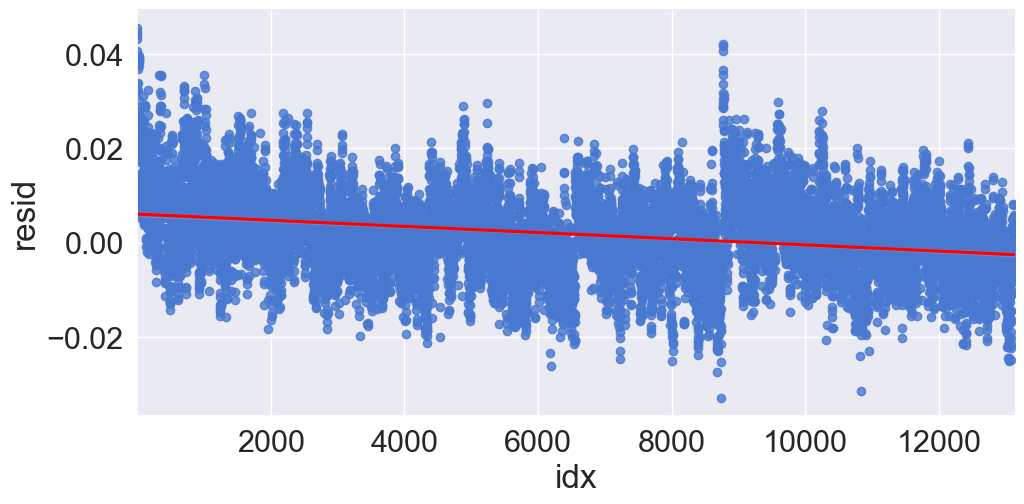

In [89]:
sb.set(palette="muted", color_codes=True, font_scale=2)
sb.lmplot(data=resid_tr.iloc[1:], x="idx", y="resid", fit_reg=True, line_kws={"color": "red"}, size=5.2, aspect=2, ci=99, sharey=True)

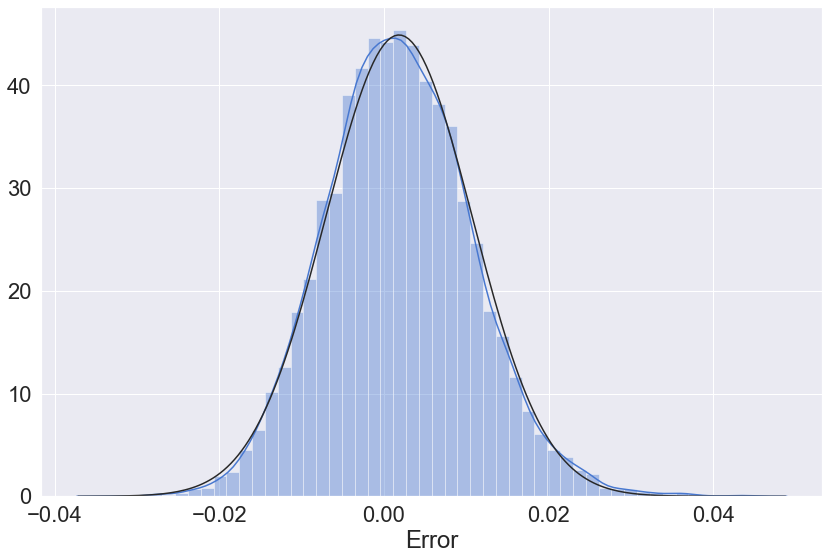

In [122]:
sb.distplot(resid_tr["resid"].iloc[1:], norm_hist="True", fit=stats.norm)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

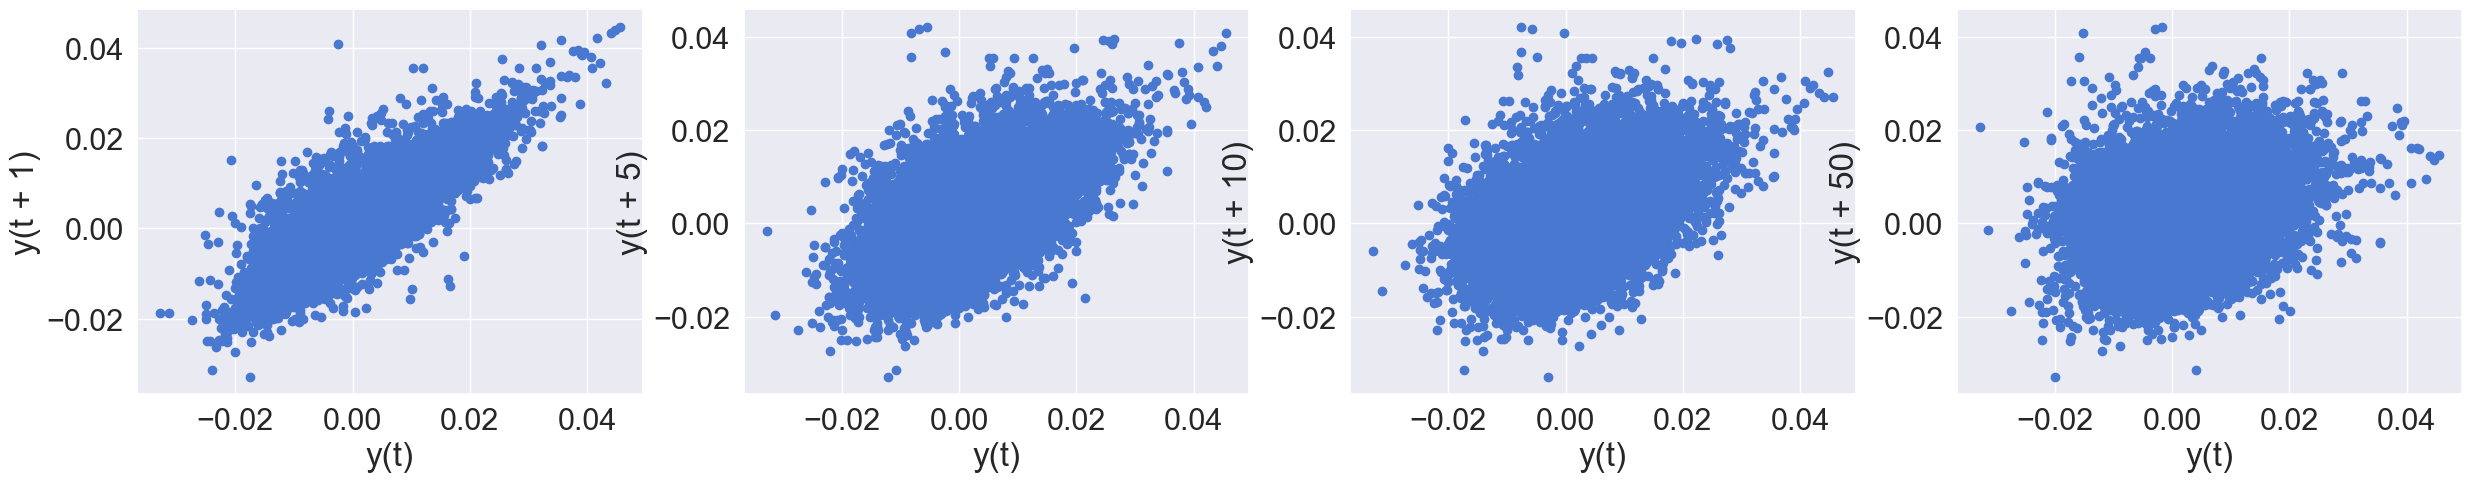

In [128]:
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
fig = pd.plotting.lag_plot(ax=axes[0], series=resid_tr["resid"].iloc[1:], lag=1)
fig = pd.plotting.lag_plot(ax=axes[1], series=resid_tr["resid"].iloc[1:], lag=5)
fig = pd.plotting.lag_plot(ax=axes[2], series=resid_tr["resid"].iloc[1:], lag=10)
fig = pd.plotting.lag_plot(ax=axes[3], series=resid_tr["resid"].iloc[1:], lag=50)

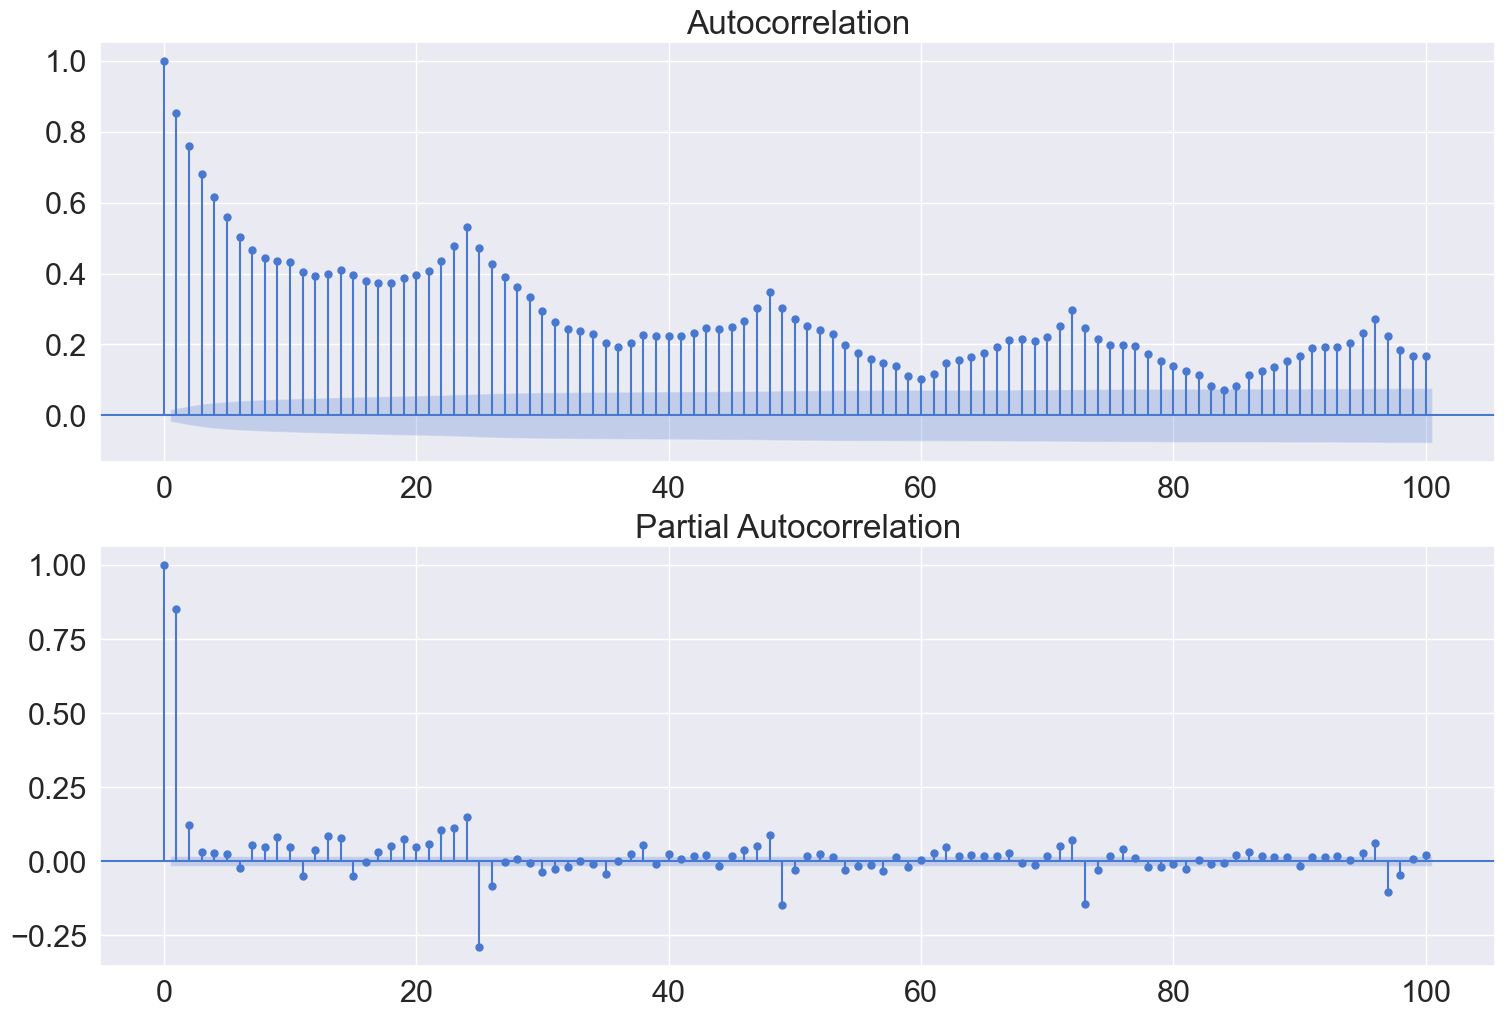

In [116]:
# Autocorrealation
fig, axes = plt.subplots(2, 1, figsize=(18, 12))
fig = sm.graphics.tsa.plot_acf(ax=axes[0], x=resid_tr["resid"].iloc[1:], lags=100, use_vlines=True)
fig = sm.graphics.tsa.plot_pacf(ax=axes[1], x=resid_tr["resid"].iloc[1:], lags=100, use_vlines=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.98,0.01,0.00,0.01,0.03,0.10,0.00
p-value,0.00,0.00,0.98,1.00,1.00,1.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),-2.86,nan,nan,nan,nan,nan,NaN
Critical Value(10%),-2.57,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"-106,845.57",nan,nan,nan,nan,nan,NaN


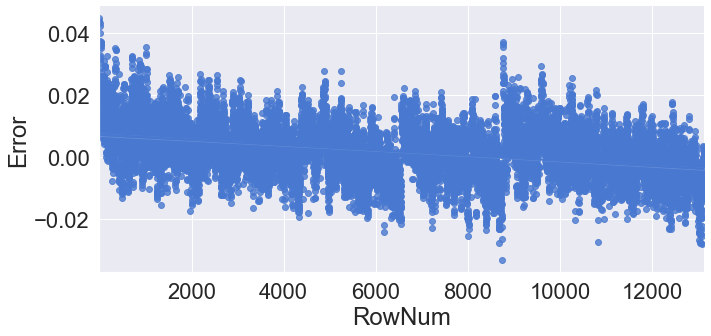

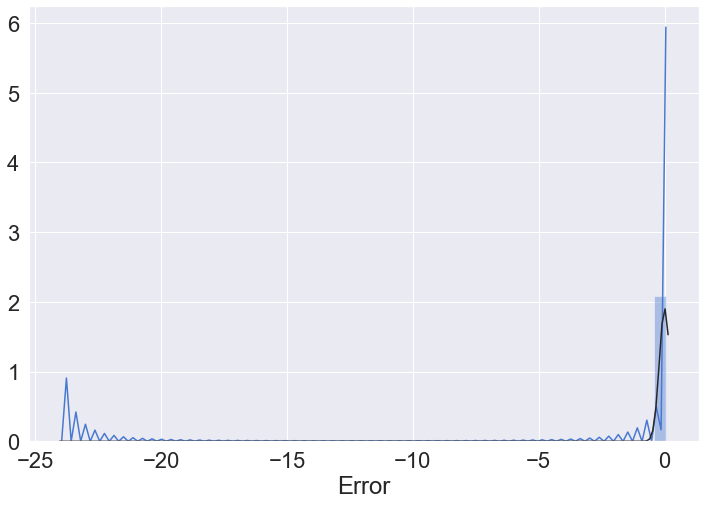

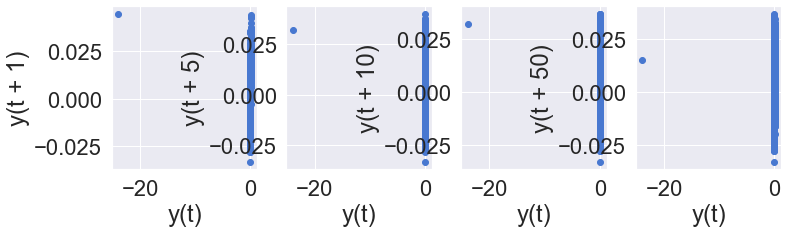

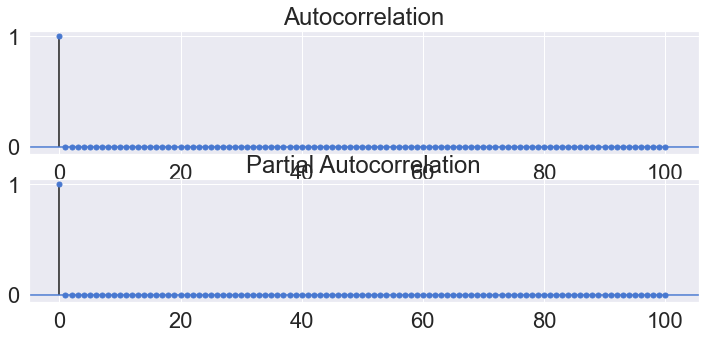

In [126]:
# Error Analysis(Plot)
resid_tr["idx"] = resid_tr.reset_index().index

# Stationarity(Trend) Analysis
sb.set(palette="muted", color_codes=True, font_scale=2)
sb.lmplot(x="idx", y="resid", data=resid_tr.iloc[1:],
           fit_reg="True", size=5.2, aspect=2, ci=99, sharey=True)

# Normal Distribution Analysis
figure, axes = plt.subplots(figsize=(12,8))
sb.distplot(resid_tr["resid"], norm_hist="True", fit=stats.norm)

# Lag Analysis
length = int(len(resid_tr["resid"])/10)
figure, axes = plt.subplots(1, 4, figsize=(12,3))
pd.plotting.lag_plot(resid_tr["resid"], lag=1, ax=axes[0])
pd.plotting.lag_plot(resid_tr["resid"], lag=5, ax=axes[1])
pd.plotting.lag_plot(resid_tr["resid"], lag=10, ax=axes[2])
pd.plotting.lag_plot(resid_tr["resid"], lag=50, ax=axes[3])

# Autocorrelation Analysis
figure, axes = plt.subplots(2,1,figsize=(12, 5))
figure = sm.graphics.tsa.plot_acf(resid_tr["resid"], lags=100, use_vlines=True, ax=axes[0])
figure = sm.graphics.tsa.plot_pacf(resid_tr["resid"], lags=100, use_vlines=True, ax=axes[1])

# Error Analysis(Statistics)
# Checking Stationarity
# Null Hypothesis: The Time-series is non-stationalry
Stationarity = pd.Series(sm.tsa.stattools.adfuller(resid_tr["resid"])[0:4], index=["Test Statistics", "p-value", "Used Lag", "Used Observations"])
for key, value in sm.tsa.stattools.adfuller(resid_tr["resid"])[4].items():
    Stationarity["Critical Value(%s)"%key] = value
Stationarity["Maximum Information Criteria"] = sm.tsa.stattools.adfuller(resid_tr["resid"])[5]
Stationarity = pd.DataFrame(Stationarity, columns=["Stationarity"])

# Checking of Normality
# Null Hypothesis: The residuals are normally distributed
Normality = pd.DataFrame([stats.shapiro(resid_tr["resid"])], index=["Normality"], columns=["Test Statistics", "p-value"]).T

# Checking for Autocorrelation
# Null Hypothesis: Autocorrelation is absent
Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(resid_tr["resid"], lags=[1,5,10,50])[0], columns=["Test Statistics"]),
                             pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(resid_tr["resid"], lags=[1,5,10,50])[1], columns=["p-value"])], axis=1).T
Autocorrelation.columns = ["Autocorr(lag1)", "Autocorr(lag5)", "Autocorr(lag10)", "Autocorr(lag50)"]

# Checking Heteroscedasticity
# Null Hypothesis: Error terms are homoscedastic
Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(resid_tr["resid"], X_train.values, alternative="two-sided")],
                                  index=["Heteroscedasticity"], columns=["Test Statistics", "p-value", "Alternative"]).T
Error_Analysis = pd.concat([Stationarity, Normality, Autocorrelation, Heteroscedasticity], join="outer", axis=1)
Error_Analysis = Error_Analysis.loc[["Test Statistics", "p-value", "Alternative", "Used Lag", "Used Observations",
                                     "Critical Value(1%)", "Critical Value(5%)", "Critical Value(10%)",
                                     "Maximum Information Criteria"],:]
Error_Analysis

## Code Summary

In [127]:
### Functionalize
### Error analysis
def stationarity_adf_te(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=["Test Statistics", "p-value", "Used Lag", "Used Observations"])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf["Critical Value(%s)"%key] = value
            Stationarity_adf["Maximum Information Criteria"] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=["Stationarity_adf"])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=["Test Statistics", "p-value", "Used Lag", "Used Observations"])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf["Critical Value(%s)"%key] = value
            Stationarity_adf["Maximum Information Criteria"] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=["Stationarity_adf"])
    return Stationarity_adf

def stationarity_kpss_te(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=["Test Statistics", "p-value", "Used Lag"])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss["Critical Value(%s)"%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=["Stationarity_kpss"])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=["Test Statistics", "p-value", "Used Lag"])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss["Critical Value(%s)"%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=["Stationarity_kpss"])
    return Stationarity_kpss

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data["idx"] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sb.set(palette="muted", color_codes=True, font_scale=2)
        sb.lmplot(x="idx", y=Target_name, data=Y_Data, fit_reg="True", size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data["idx"]

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sb.distplot(Y_Data[Target_name], norm_hist="True", fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12, 5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_te(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_te(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=["Normality"], columns=["Test Statistics", "p-value"]).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=["Test Statistics"]),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=["p-value"])], axis=1).T
    Autocorrelation.columns = ["Autocorr(lag1)", "Autocorr(lag5)", "Autocorr(lag10)", "Autocorr(lag50)"]

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative="two-sided")],
                                      index=["Heteroscedasticity"], columns=["Test Statistics", "p-value", "Alternative"]).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join="outer", axis=1)
    index_new = ["Test Statistics", "p-value", "Alternative", "Used Lag", "Used Observations",
                 "Critical Value(1%)", "Critical Value(5%)", "Critical Value(10%)", "Maximum Information Criteria"]
    Score.reindex(index_new)
    return Score
# error_analysis(resid_tr[1:], ["resid"], X_train, graph_on=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.98,0.09,0.01,0.00,0.01,0.03,0.10,0.00
p-value,0.00,0.10,0.00,0.98,1.00,1.00,1.00,0.00
Used Lag,41.00,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"-106,845.57",nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided


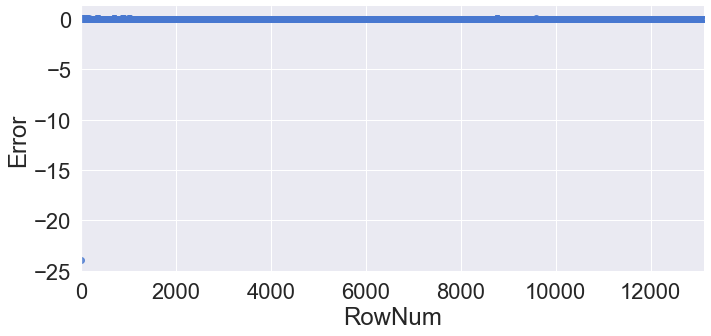

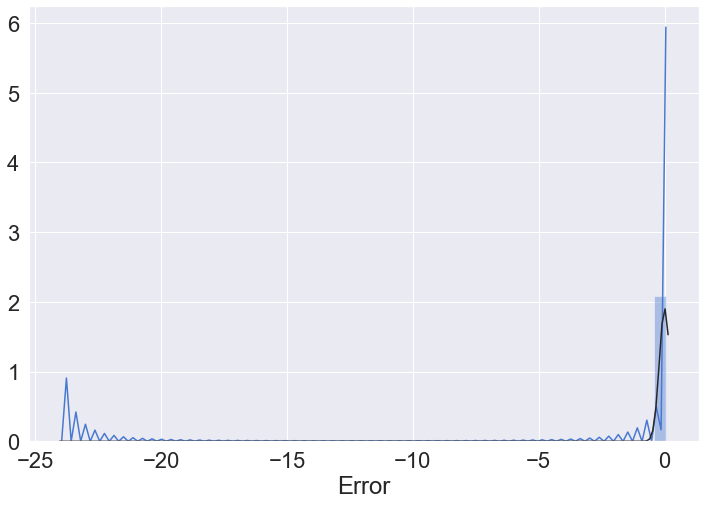

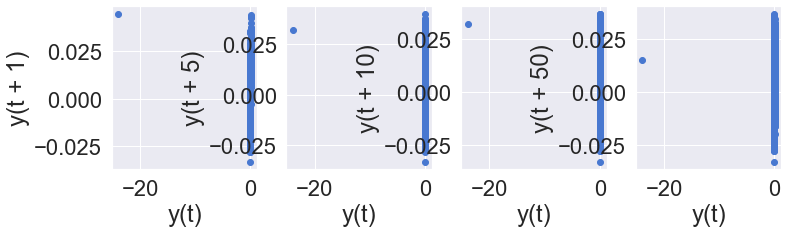

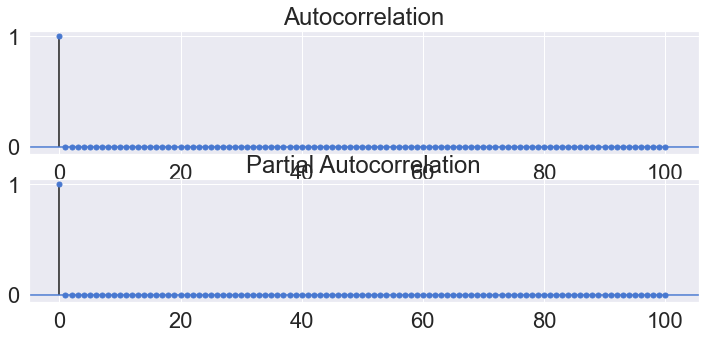

In [128]:
error_analysis(resid_tr, ["resid"], X_train, graph_on=True)
# 정상성 / 비정규분포 / 자기상관없음 / 등분산아님

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.82,7.52,1.00,"9,615.96","32,903.39","47,262.88","116,653.97",2.10
p-value,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
Used Lag,41.00,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,085.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"-106,838.93",nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided


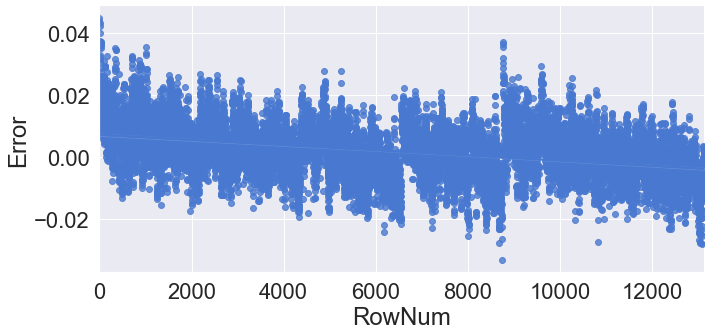

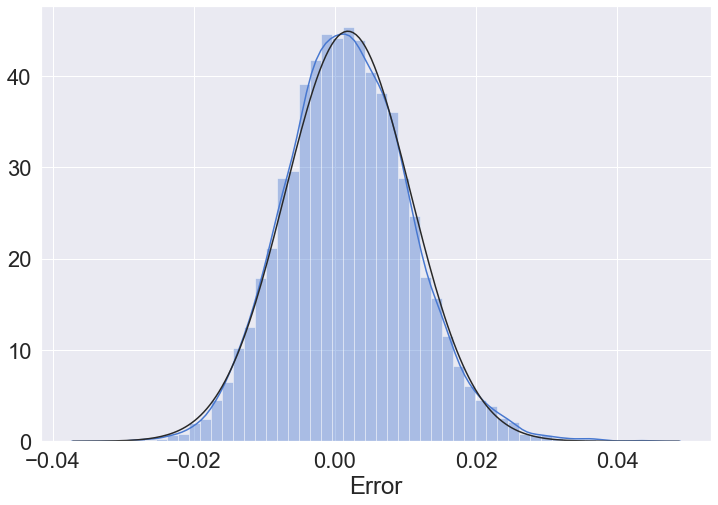

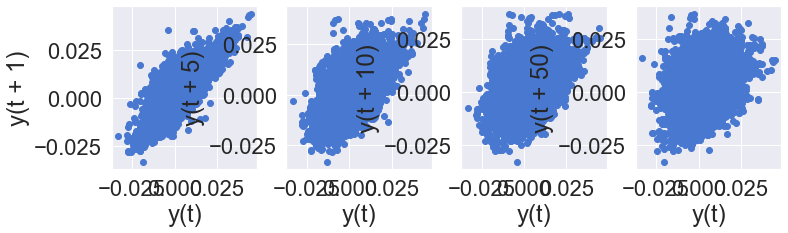

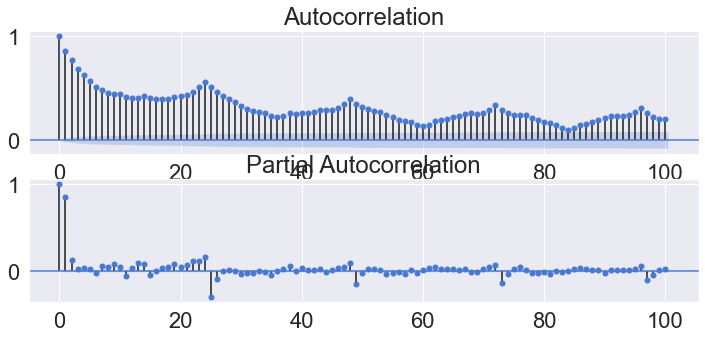

In [129]:
error_analysis(resid_tr.iloc[1:], ["resid"], X_train, graph_on=True)
# 정상성(ADf) / 비정상성(KPSS) / 비정규분포 / 자기상관있음 / 등분산아님

# Summary: insufficient for me
**1) 데이터 핸들링**  

**2) 단계이해**  
>**1. Import Library**  
**2. Data Loading**  [(Data Source and Description)](https://www.kaggle.com/c/bike-sharing-demand/data)  
**3. Feature Engineering(Rearrange of Data)**  
**4. Data Understanding(Descriptive Statistics and Getting Insight from Features)**  
**5. Data Split: Train/Validate/Test Sets**  
**6. Applying Base Model**  
**7. Evaluation**  
**8. Error Analysis** 

**3) 결과 해석**  

## Code Summary (Raw Data)

Train_size: (13128, 12) Test_size: (4416, 12)
X_train: (13128, 8) Y_train: (13128, 1)
X_test: (4416, 8) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.638
Model:                            OLS   Adj. R-squared (uncentered):              0.638
Method:                 Least Squares   F-statistic:                              2889.
Date:                Mon, 14 Sep 2020   Prob (F-statistic):                        0.00
Time:                        23:23:47   Log-Likelihood:                         -83421.
No. Observations:               13128   AIC:                                  1.669e+05
Df Residuals:                   13120   BIC:                                  1.669e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season         3.3659      1.286      2.618      0.009       0.846       5.886
holiday       -6.2896      7.466     -0.842      0.400     -20.924       8.345
workingday    10.3553      2.641      3.921      0.000       5.178      15.533
weather        7.1906      2.093      3.436      0.001       3.089      11.292
temp          -7.8544      1.222     -6.429      0.000     -10.249      -5.460
atemp         16.0695      1.095     14.676      0.000      13.923      18.216
humidity      -1.7353      0.063    -27.356      0.000      -1.860      -1.611
windspeed      2.2749      0.136     16.745      0.000       2.009       2.541
==============================================================================
Omnibus:                     2168.771   Durbin-Watson:                   0.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3942.747
Skew:                           1.050   Prob(JB):                         0.00
Kurtosis:                       4.672   Cond. No.                         450.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,MAE,MSE,MAPE
Train,103.09,"19,360.42",458.48
Test,150.03,"43,410.27",316.61


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.25,11.19,0.94,"8,204.84","12,494.43","13,138.03","48,485.56",1.76
p-value,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
Used Lag,40.00,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,087.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"143,252.82",nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided


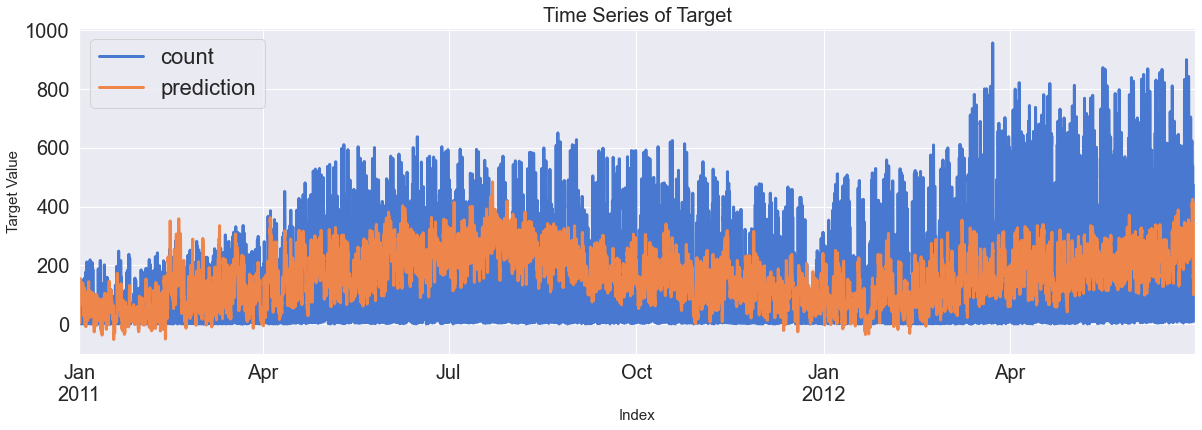

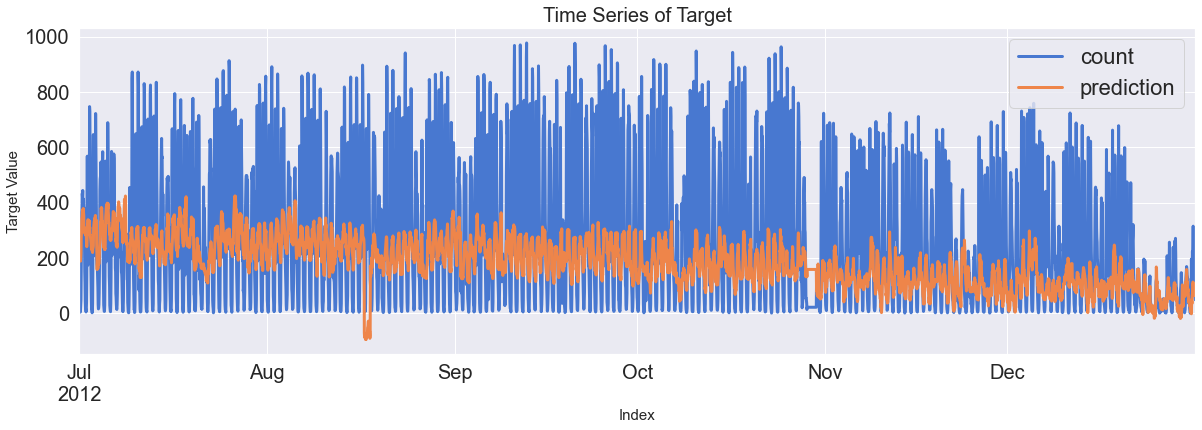

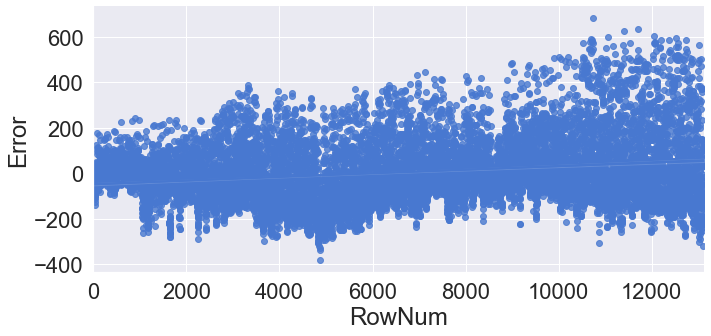

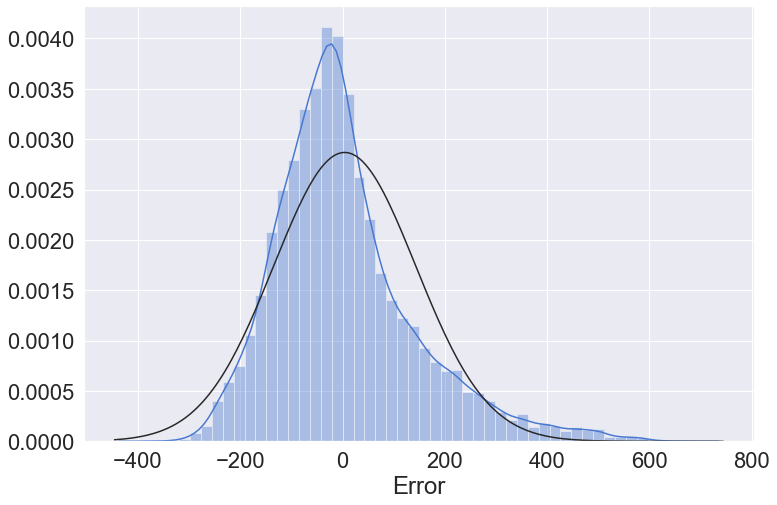

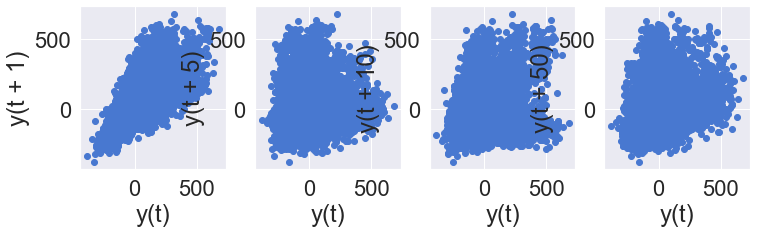

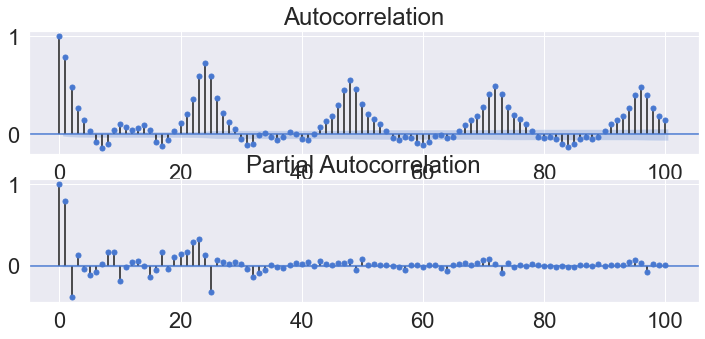

In [130]:
# Data Loading
# location = "https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv"
location = "./Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv"
raw_data = pd.read_csv(location)

# Feature Engineering
raw_rd = non_feature_engineering(raw_data)

# Data Split
# Confirm of input and output
y_cols = ["count"]
X_remove = ["datetime", "DateTime", "temp_group", "casual", "registered"]
x_cols = [x for x in raw_rd.columns if x not in y_cols+X_remove]
X_train_rd, X_te_rd, y_tr_rd, Y_te_rd = datasplit_ts(raw_rd, y_cols, x_cols, "2012-07-01")

# Applying Base Model
fit_reg1_rd = sm.OLS(y_tr_rd, X_train_rd).fit()
display(fit_reg1_rd.summary())
pred_tr_reg1_rd = fit_reg1_rd.predict(X_train_rd).values
pred_te_reg1_rd = fit_reg1_rd.predict(X_te_rd).values

# Evaluation
Score_reg1_rd, resid_tr_rd, Resid_te_reg1_rd = evaluation_trte(y_tr_rd, pred_tr_reg1_rd, 
                                                                Y_te_rd, pred_te_reg1_rd, graph_on=True)
display(Score_reg1_rd)

# Error Analysis
error_analysis(resid_tr_rd, ["resid"], X_train_rd, graph_on=True)

## Code Summary (Feature Engineering Data)

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.362e+08
Date:                Mon, 14 Sep 2020   Prob (F-statistic):               0.00
Time:                        23:23:53   Log-Likelihood:                 1906.2
No. Observations:               13128   AIC:                            -3764.
Df Residuals:                   13104   BIC:                            -3585.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season            -0.0005      0.004     -0.129      0.897      -0.009       0.008
holiday            0.0083      0.014      0.612      0.540      -0.018       0.035
workingday         0.0079      0.007      1.184      0.236      -0.005       0.021
weather            0.0042      0.003      1.232      0.218      -0.003       0.011
temp               0.0022      0.002      1.075      0.282      -0.002       0.006
atemp             -0.0025      0.002     -1.347      0.178      -0.006       0.001
humidity          -0.0001      0.000     -0.845      0.398      -0.000       0.000
windspeed          0.0003      0.000      1.062      0.288      -0.000       0.001
count_trend     9.161e-05   8.57e-05      1.069      0.285   -7.64e-05       0.000
count_seasonal  1.984e-05   2.56e-05      0.775      0.438   -3.03e-05       7e-05
count_Day       4.177e-05   8.36e-05      0.500      0.617      -0.000       0.000
count_Week     -4.345e-05   9.61e-05     -0.452      0.651      -0.000       0.000
count_diff         1.0000    2.9e-05   3.45e+04      0.000       1.000       1.000
Year           -1.547e-05   7.97e-06     -1.939      0.052   -3.11e-05    1.66e-07
Quater_ver2        0.0004      0.002      0.180      0.857      -0.004       0.005
Month              0.0026      0.002      1.051      0.293      -0.002       0.007
Day                0.0004      0.000      1.728      0.084   -4.91e-05       0.001
Hour               0.0006      0.000      1.538      0.124      -0.000       0.001
DayofWeek          0.0003      0.002      0.224      0.823      -0.003       0.003
count_lag1         1.0000    2.7e-05    3.7e+04      0.000       1.000       1.000
count_lag2     -1.926e-05   2.59e-05     -0.744      0.457      -7e-05    3.15e-05
Quater_Dummy_2    -0.0010      0.009     -0.115      0.909      -0.019       0.017
Quater_Dummy_3    -0.0037      0.017     -0.220      0.826      -0.037       0.030
Quater_Dummy_4    -0.0132      0.026     -0.512      0.609      -0.064       0.037
==============================================================================
Omnibus:                    54426.083   Durbin-Watson:                   1.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      93552024983.828
Skew:                        -114.255   Prob(JB):                         0.00
Kurtosis:                   13078.751   Cond. No.                     3.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,MAE,MSE,MAPE
Train,0.01,0.04,0.06
Test,0.01,0.00,0.03


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.98,0.09,0.01,0.00,0.01,0.03,0.10,0.00
p-value,0.00,0.10,0.00,0.98,1.00,1.00,1.00,0.00
Used Lag,41.00,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"-106,845.57",nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided


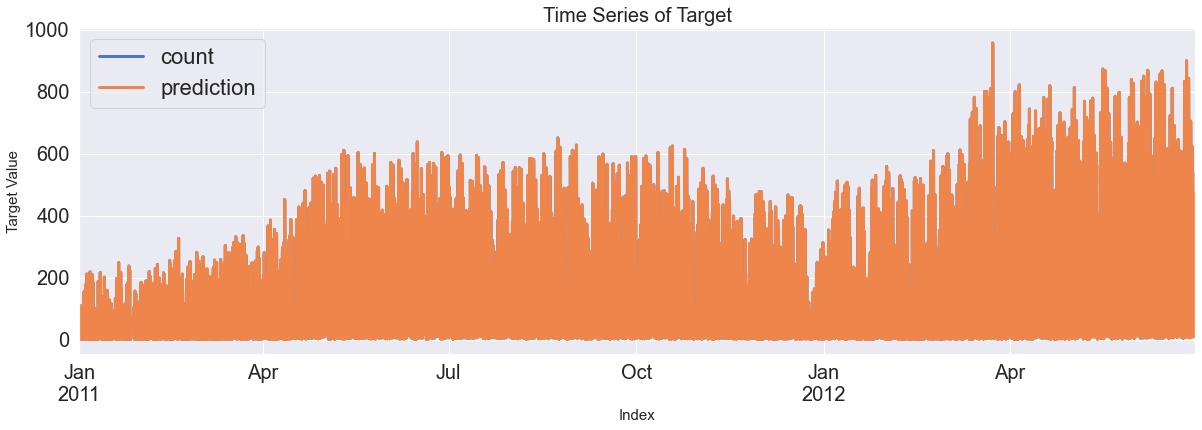

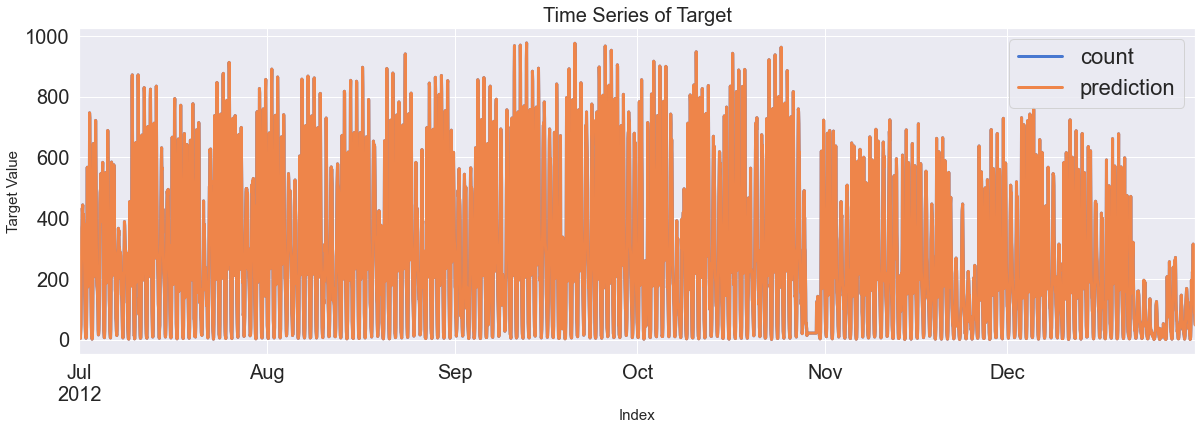

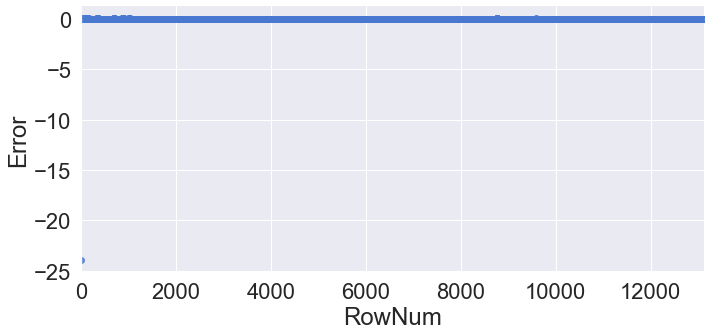

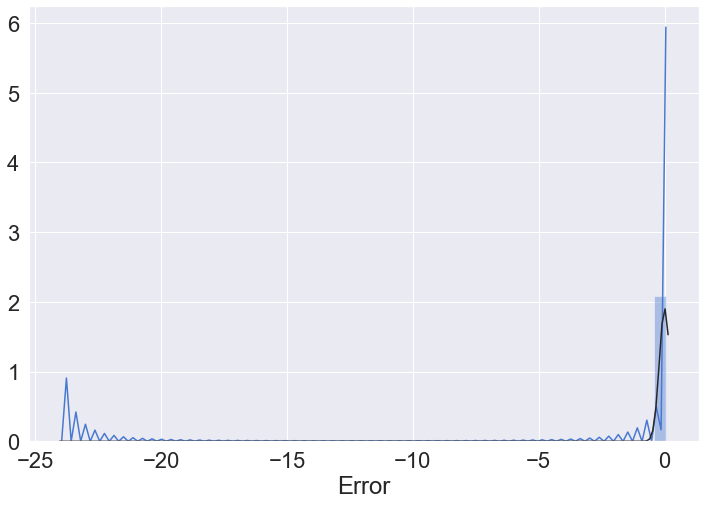

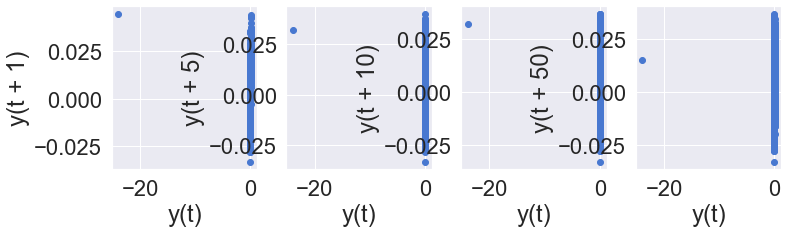

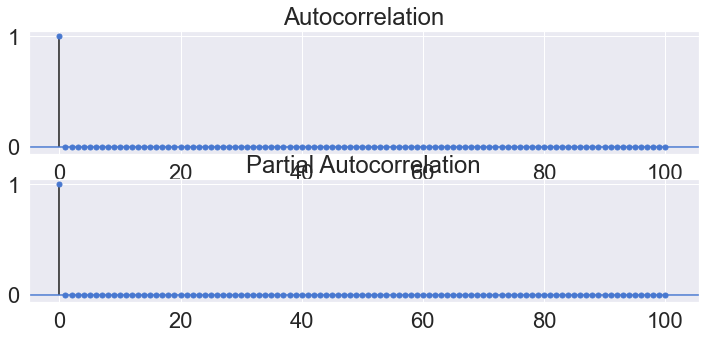

In [131]:
# Data Loading
# location = "https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv"
location = "./Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv"
raw_data = pd.read_csv(location)

# Feature Engineering
data = feature_engineering(raw_data)

# Data Split
# Confirm of input and output
y_cols = ["count"]
X_remove = ["datetime", "DateTime", "temp_group", "casual", "registered"]
x_cols = [x for x in data.columns if x not in y_cols+X_remove]
X_train_fe, X_te_fe, y_tr_fe, Y_te_fe = datasplit_ts(data, y_cols, x_cols, "2012-07-01")

# Applying Base Model
fit_reg1_fe = sm.OLS(y_tr_fe, X_train_fe).fit()
display(fit_reg1_fe.summary())
pred_tr_reg1_fe = fit_reg1_fe.predict(X_train_fe).values
pred_te_reg1_fe = fit_reg1_fe.predict(X_te_fe).values

# Evaluation
Score_reg1_fe, resid_tr_fe, Resid_te_reg1_fe = evaluation_trte(y_tr_fe, pred_tr_reg1_fe,
                                                                Y_te_fe, pred_te_reg1_fe, graph_on=True)
display(Score_reg1_fe)

# Error Analysis
error_analysis(resid_tr_fe, ["resid"], X_train_fe, graph_on=True)